## Load Base Stable Diffusion Model

In [1]:
from diffusers import StableDiffusionPipeline
from pruna.algorithms.smasher_config import AutoSmasherConfig
from pruna.smash import smash
import torch
import requests
from PIL import Image
from io import BytesIO

from diffusers import StableDiffusionInpaintPipeline

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float16,
)
image = Image.open(
            BytesIO(
                requests.get(
                    "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
                ).content
            )
        )
mask_image = Image.open(
            BytesIO(
                requests.get(
                    "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"
                ).content
            )
        )
prompt = "cat"
#image and mask_image should be PIL images.
#The mask structure is white for inpainting and black for keeping as is
pipe.to('cuda')
# image = pipe(prompt=prompt, image=image, mask_image=mask_image).images[0]

Post-training Optimization Tool is deprecated and will be removed in the future. Please use Neural Network Compression Framework instead: https://github.com/openvinotoolkit/nncf
Nevergrad package could not be imported. If you are planning to use any hyperparameter optimization algo, consider installing it using pip. This implies advanced usage of the tool. Note that nevergrad is compatible only with Python 3.7+
vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


StableDiffusionInpaintPipeline {
  "_class_name": "StableDiffusionInpaintPipeline",
  "_diffusers_version": "0.23.0",
  "_name_or_path": "runwayml/stable-diffusion-inpainting",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

## Smash it!

In [2]:
from pruna.algorithms.smasher_config import SmasherConfig

smasher_config = SmasherConfig()
smasher_config['compiler'] = 'diffusers'
smasher_config['max_batch_size'] = 1
smasher_config['image_height'] = 512
smasher_config['image_width'] = 512
smasher_config['version'] = '1.5'
smasher_config['static_shape'] = False
smasher_config['unet_dim'] = 9
smasher_config['scheduler'] = "PNDM"

In [3]:
smashed_model = smash(
        model=pipe,
        data_module="inpaint",
        api_key='your-api-key',
        model_config=None,
        smasher_config=smasher_config,
        device='cuda',
    )

Received a 500 error, retrying in 3 seconds...
Compile...
[I] Load tokenizer pytorch model from: /nfs/students/rachwan/huggingface/.cache/torch/1.5/INPAINT/tokenizer
Loading TensorRT engine: /nfs/students/rachwan/huggingface/.cache/engine/vae_encoder_inpaint.plan
Loading TensorRT engine: /nfs/students/rachwan/huggingface/.cache/engine/clip_inpaint.plan
Loading TensorRT engine: /nfs/students/rachwan/huggingface/.cache/engine/unet_inpaint.plan
Loading TensorRT engine: /nfs/students/rachwan/huggingface/.cache/engine/vae_inpaint.plan
Success.


## Base Model Generation

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 2.67 s, sys: 11.5 ms, total: 2.68 s
Wall time: 2.4 s


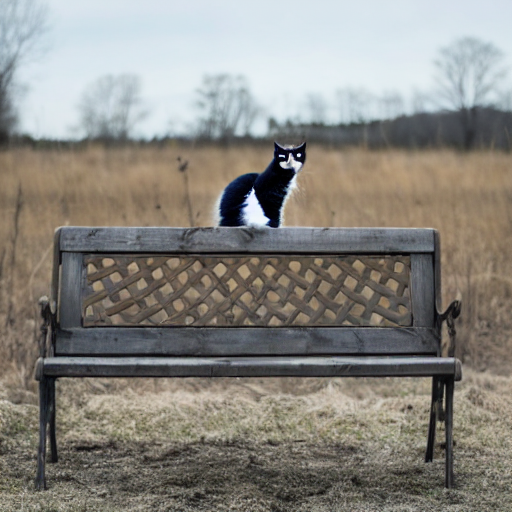

In [20]:
%%time
pipe(prompt=prompt, image=image, mask_image=mask_image).images[0]

## Smashed Model Generation

CPU times: user 597 ms, sys: 242 ms, total: 839 ms
Wall time: 737 ms


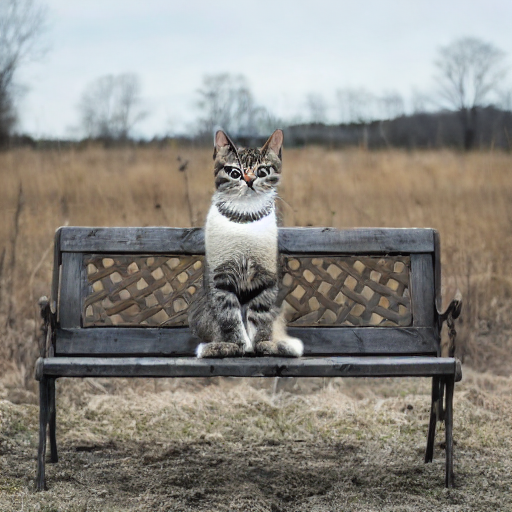

In [21]:
%%time
smashed_model(prompt, input_image=image, mask_image=mask_image, image_height=512, image_width=512, strength=0.75, num_inference_steps=50)[0]